In [52]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/zillow-prize-1/properties_2017.csv
/kaggle/input/zillow-prize-1/sample_submission.csv
/kaggle/input/zillow-prize-1/zillow_data_dictionary.xlsx
/kaggle/input/zillow-prize-1/train_2016_v2.csv
/kaggle/input/zillow-prize-1/properties_2016.csv
/kaggle/input/zillow-prize-1/train_2017.csv


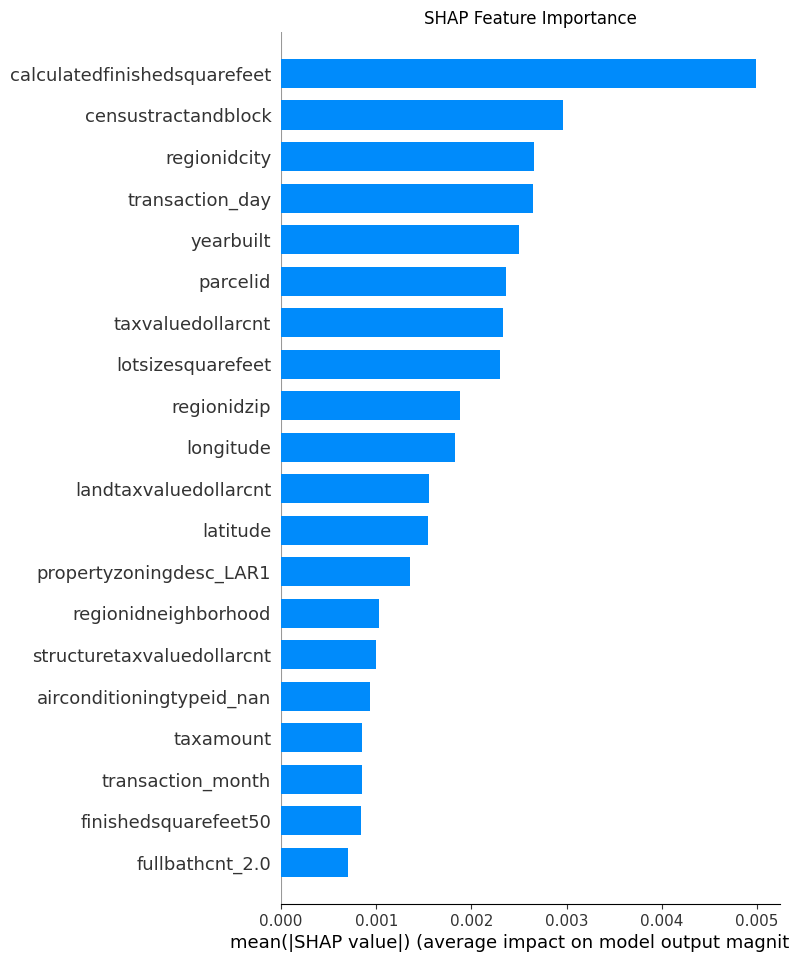

In [60]:
# 필요한 라이브러리 설치 확인 (Kaggle에서 필요 시 실행)
!pip install catboost shap scikit-optimize --quiet

# 라이브러리 임포트
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression  # Meta-Learner로 사용
from sklearn.ensemble import RandomForestRegressor  # RandomForestRegressor 추가
from skopt import BayesSearchCV
from skopt.space import Categorical, Integer, Real  # skopt.space 임포트 추가
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
import shap
import joblib
from sklearn.base import clone
import psutil  # 메모리 모니터링
import gc  # 가비지 컬렉션
import tensorflow as tf
from scipy import sparse
from sklearn.ensemble import ExtraTreesRegressor
import matplotlib.pyplot as plt  # matplotlib 추가
import seaborn as sns  # seaborn 추가
from IPython.display import clear_output, display  # Kaggle 출력용

# GPU 사용 확인 및 설정
print("TensorFlow 버전:", tf.__version__)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print("GPU 사용 가능:", gpus)
else:
    print("GPU 사용 불가능, CPU로 실행됩니다.")

# 전처리 함수: 학습 데이터와 테스트 데이터에 동일한 처리를 적용 (행 삭제는 학습 데이터에만)
def preprocess_data(train_df, test_df, sample_submission=None, train_processed=None):
    """
    학습 데이터와 테스트 데이터를 합쳐 범주형 피처 인코딩 후 분리해 전처리하는 함수.
    
    Parameters:
      - train_df: 학습 데이터 (예: train_2016, train_2017 병합된 데이터)
      - test_df: 테스트 데이터 (예: properties 병합 후, sample_submission 기준 필터링)
      - sample_submission: 테스트 데이터의 ParcelId와 시간대 정보를 위한 샘플 제출 파일
      - train_processed: (선택) 학습 데이터 전처리 결과 (타겟 인코딩 참조)
    
    Returns:
      - processed_train, processed_test: 전처리된 학습 및 테스트 데이터프레임
    """
    # 1. 중요 피처와 불필요한 피처 설정
    important_features = [
        'latitude', 'longitude', 'lotsizesquarefeet', 'calculatedfinishedsquarefeet',
        'finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15',
        'finishedsquarefeet50', 'finishedsquarefeet6', 'bathroomcnt', 'bedroomcnt',
        'yearbuilt', 'ParcelId'
    ]
    irrelevant_cols = ['unitcnt', 'rawcensustractandblock', 'fips']
    
    def clean_data(df):
        # 결측치 비율 50% 초과인 칼럼 제거 (ParcelId 보존)
        df_no_id = df.drop(columns=['ParcelId'] if 'ParcelId' in df.columns else [])
        missing_ratio = df_no_id.isnull().sum() / len(df) * 100
        cols_to_drop = missing_ratio[(missing_ratio > 50) & (~missing_ratio.index.isin(important_features))].index
        df_filtered = df.drop(columns=cols_to_drop)
        return df_filtered
    
    train_clean = clean_data(train_df)
    test_clean = clean_data(test_df)
    
    # 불필요한 피처 제거 (관련성 낮은 피처)
    train_clean = train_clean.drop(columns=irrelevant_cols, errors='ignore')
    test_clean = test_clean.drop(columns=irrelevant_cols, errors='ignore')
    
    # 2. 날짜 처리
    if 'transactiondate' in train_clean.columns:
        train_clean['transactiondate'] = pd.to_datetime(train_clean['transactiondate'])
        train_clean['transaction_year'] = train_clean['transactiondate'].dt.year
        train_clean['transaction_month'] = train_clean['transactiondate'].dt.month
        train_clean['transaction_day'] = train_clean['transactiondate'].dt.day
        train_clean = train_clean.drop(columns=['transactiondate'])
    if sample_submission is not None:
        # 테스트 데이터: 시점별 데이터를 생성하여 날짜 정보 부여
        if 'ParcelId' not in test_clean.columns:
            print("[오류] test_clean에 'ParcelId' 열이 없습니다. 기본 시간대 값을 설정합니다.")
            test_clean['transaction_year'] = 2016
            test_clean['transaction_month'] = 10
            test_clean['transaction_day'] = 1
        else:
            time_points = ['201610', '201611', '201612', '201710', '201711', '201712']
            test_dfs = []
            for time_point in time_points:
                year = int(time_point[:4])
                month = int(time_point[4:])
                temp_df = test_clean.copy()
                temp_df['transaction_year'] = year
                temp_df['transaction_month'] = month
                temp_df['transaction_day'] = 1
                temp_df['timepoint'] = time_point
                test_dfs.append(temp_df)
            test_clean = pd.concat(test_dfs, ignore_index=True)
    
    # 3. 학습과 테스트 데이터를 합쳐서 인코딩 적용
    combined_df = pd.concat([train_clean, test_clean], keys=['train', 'test'], names=['dataset_type'])
    combined_df.reset_index(level='dataset_type', inplace=True)
    dataset_type = combined_df['dataset_type'].copy()  # 나중에 분리할 때 사용

    # 4. 범주형 데이터 식별 (dataset_type 제외)
    categorical_cols = combined_df.select_dtypes(include=['object', 'category']).columns.tolist()
    # "dataset_type"은 이후 X_combined에서 제거되므로 미리 빼줍니다.
    categorical_cols = [col for col in categorical_cols if col not in ['dataset_type']]
    numeric_cols = combined_df.select_dtypes(include=['int32', 'float64']).columns.tolist()
    for col in numeric_cols:
        if col not in ['transaction_year', 'transaction_month', 'transaction_day', 'logerror'] and len(combined_df[col].value_counts()) <= 20:
            categorical_cols.append(col)
    categorical_cols = list(set(categorical_cols) - set(['parcelid']))
    print("총 범주형 데이터:", categorical_cols)

    # 5. ColumnTransformer를 사용해 수치형은 스케일링, 범주형은 OneHotEncoder (희소행렬 유지, drop='first' 제거)
    num_features = [col for col in numeric_cols if col not in categorical_cols and col != 'logerror']
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(with_mean=False), num_features),
            ('cat', OneHotEncoder(drop=None, sparse_output=True, handle_unknown='ignore'), categorical_cols)  # drop=None으로 수정
        ],
        remainder='passthrough'
    )
    
    # 6. 'logerror'가 있다면 별도 저장, combined_df에서 제거하고 인코딩 적용
    if 'logerror' in combined_df.columns:
        y_combined = combined_df['logerror']
        X_combined = combined_df.drop(columns=['logerror', 'dataset_type'], errors='ignore')
    else:
        X_combined = combined_df.drop(columns=['dataset_type'], errors='ignore')
        y_combined = None

    X_processed = preprocessor.fit_transform(X_combined)
    feature_names = (preprocessor.named_transformers_['num'].get_feature_names_out().tolist() +
                     preprocessor.named_transformers_['cat'].get_feature_names_out().tolist() +
                     [col for col in X_combined.columns if col not in num_features and col not in categorical_cols])
    
    # 7. 처리 결과가 희소행렬인 경우 밀집행렬로 변환
    if sparse.issparse(X_processed):
        X_dense = X_processed.toarray()
        processed_df = pd.DataFrame(X_dense, columns=feature_names, index=X_combined.index)
    else:
        processed_df = pd.DataFrame(X_processed, columns=feature_names, index=X_combined.index)
    
    # dataset_type 및 logerror 복원
    processed_df['dataset_type'] = dataset_type
    if y_combined is not None:
        processed_df['logerror'] = y_combined
    
    # 8. 학습/테스트 데이터 분리
    processed_train = processed_df[processed_df['dataset_type'] == 'train'].drop(columns=['dataset_type']).reset_index(drop=True)
    processed_test = processed_df[processed_df['dataset_type'] == 'test'].drop(columns=['dataset_type']).reset_index(drop=True)
    
    # 데이터 검증: 결측치 및 비어 있는 열 점검
    if processed_train.empty or 'logerror' not in processed_train.columns:
        raise ValueError("processed_train이 비어 있거나 'logerror' 열이 누락되었습니다.")
    
    # 9. 이상치 처리 (학습 데이터에만)
    if 'logerror' in processed_train.columns:
        print("이상치 처리 시작...")
        plt.figure(figsize=(10, 6))
        sns.boxplot(x=processed_train['logerror'])
        plt.title("logerror Boxplot")
        plt.show()
        
        logerror_lower, logerror_upper = processed_train['logerror'].quantile([0.01, 0.99])
        print(f"logerror 1% 분위수: {logerror_lower:.4f}, 99% 분위수: {logerror_upper:.4f}")
        processed_train = processed_train[processed_train['logerror'].between(logerror_lower, logerror_upper, inclusive='both')]
        # 추가 수치형 피처 이상치 처리는 상황에 따라 추가 가능
        
        plt.figure(figsize=(10, 6))
        sns.boxplot(x=processed_train['logerror'])
        plt.title("logerror Boxplot (이상치 제거 후)")
        plt.show()
    
    # 10. 최종 결측치 처리 (학습 및 테스트 데이터)
    for df in [processed_train, processed_test]:
        num_cols_df = df.select_dtypes(include=['int32', 'float64']).columns
        # 제거된 열을 제외한 num_cols_df 업데이트
        num_cols_df = [col for col in num_cols_df if col in df.columns]
        miss_ratio = df[num_cols_df].isnull().mean()
        cols_to_drop = miss_ratio[miss_ratio > 0.9].index
        if len(cols_to_drop) > 0:
            print(f"[주의] 결측치 비율 90% 이상 칼럼 제거: {list(cols_to_drop)}")
            df.drop(columns=cols_to_drop, inplace=True)

        # 제거된 열 제외 후 결측치 처리
        for col in num_cols_df:
            if col in df.columns and df[col].isnull().sum() > 0:  # 열 존재 여부 확인
                if col in ['finishedsquarefeet15', 'finishedsquarefeet6', 'lotsizesquarefeet', 'garagetotalsqft']:
                    df[col] = df[col].fillna(0)
                else:
                    df[col] = df[col].fillna(df[col].median())
    
    print("\n최종 결측치 처리 완료.")
    return processed_train, processed_test

# 데이터 로드 (dtype 문제 해결을 위해 low_memory=False 추가)
train_2016 = pd.read_csv('/kaggle/input/zillow-prize-1/train_2016_v2.csv', low_memory=False)
train_2017 = pd.read_csv('/kaggle/input/zillow-prize-1/train_2017.csv', low_memory=False)
properties_2016 = pd.read_csv('/kaggle/input/zillow-prize-1/properties_2016.csv', low_memory=False)
properties_2017 = pd.read_csv('/kaggle/input/zillow-prize-1/properties_2017.csv', low_memory=False)
sample_submission = pd.read_csv('/kaggle/input/zillow-prize-1/sample_submission.csv', low_memory=False)

# properties 병합: properties_2017의 결측치는 properties_2016의 값으로 대체
properties = properties_2017.copy()
for col in properties_2017.columns:
    properties[col] = properties_2017[col].fillna(properties_2016[col])

# train 데이터 병합 (2016과 2017 거래 데이터 합치기, 그리고 properties와 병합)
train_df = pd.concat([train_2016, train_2017], axis=0, ignore_index=True)
train_df = train_df.merge(properties, on='parcelid', how='left')

# test 데이터 준비: sample_submission에 있는 ParcelId를 기준으로 필터링 후 컬럼 이름 변경
test_df = properties[properties['parcelid'].isin(sample_submission['ParcelId'])].copy()
test_df = test_df.rename(columns={'parcelid': 'ParcelId'})
print("test_df 초기 열 목록:", test_df.columns.tolist())

# 샘플 데이터로 테스트 (1000행 샘플링 유지)
train_df_sample = train_df.sample(1000, random_state=42)
test_df_sample = test_df.sample(100, random_state=42)

# 전처리 실행
try:
    processed_train, processed_test = preprocess_data(train_df_sample, test_df_sample, sample_submission=sample_submission)
except ValueError as e:
    print(f"데이터 전처리 오류: {e}")
    processed_train, processed_test = pd.DataFrame(), pd.DataFrame()

print("processed_train 열:", processed_train.columns.tolist())
print("processed_train 크기:", processed_train.shape)

# 17. 모델링 단계 (CatBoost, XGBoost, LightGBM, RandomForest 및 Stacking 앙상블 예시, logerror 예측 목표)
print("\n=== [17] 모델링 단계 ===")
if not processed_train.empty and 'logerror' in processed_train.columns:
    X = processed_train.drop('logerror', axis=1)
    y = processed_train['logerror']
    if y.ndim > 1:
        y = y.ravel()
    print("X 크기:", X.shape)
    print("y 크기:", y.shape)
    
    # 데이터 검증: 결측치 및 비어 있는 열 점검
    if X.isnull().any().any() or y.isnull().any():
        raise ValueError("X 또는 y에 결측치가 포함되어 있습니다.")
    
    # 메모리 상태 확인
    print("메모리 상태 (모델링 시작 전):", psutil.virtual_memory())
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    # 하이퍼파라미터 튜닝 범위 (예시로 수정, 메모리 및 시간 최적화)
    param_space_rf = {
        'n_estimators': (100, 200),
        'max_depth': (10, 15),
        'min_samples_split': (2, 5),
        'min_samples_leaf': (1, 3),
        'n_jobs': (2,)  # CPU 병렬성 제한
    }
    param_space_xgb = {
        'n_estimators': (100, 200),
        'max_depth': (10, 15),
        'learning_rate': (0.005, 0.05, 'log-uniform'),
        'reg_alpha': (0.01, 0.5, 'log-uniform'),
        'reg_lambda': (0.01, 0.5, 'log-uniform'),
        # tree_method을 최신 방식으로 수정, early_stopping_rounds 제거
        'tree_method': Categorical(['hist']),
        'device': Categorical(['cuda' if gpus else 'cpu'])
    }
    param_space_lgb = {
        'n_estimators': (100, 200),
        'max_depth': (10, 15),
        'learning_rate': (0.005, 0.05, 'log-uniform'),
        'reg_alpha': (0.01, 0.5, 'log-uniform'),
        'reg_lambda': (0.01, 0.5, 'log-uniform'),
        'min_data_in_leaf': (10, 30),
        'min_data_in_bin': (10, 30)
    }
    param_space_cb = {
        'iterations': (100, 200),
        'depth': (10, 15),
        'learning_rate': (0.005, 0.05, 'log-uniform'),
        'l2_leaf_reg': (1, 5, 'log-uniform'),
        # task_type을 Categorical로 정의
        'task_type': Categorical(['GPU' if gpus else 'CPU'])
    }
    
    n_iter = 10  # 반복 수 축소 (학습시간 단축)

    # 모델 튜닝 (모델별 early_stopping_rounds 및 eval_set 적용, LightGBM 수정)
    opt_rf = BayesSearchCV(
        RandomForestRegressor(random_state=42),
        param_space_rf, n_iter=n_iter, cv=kf, scoring='neg_mean_absolute_error', n_jobs=2
    )
    opt_xgb = BayesSearchCV(
        xgb.XGBRegressor(random_state=42, tree_method='hist', device='cuda' if gpus else 'cpu'),  # early_stopping_rounds 제거
        param_space_xgb, n_iter=n_iter, cv=kf, scoring='neg_mean_absolute_error', n_jobs=1
    )
    opt_lgb = BayesSearchCV(
        lgb.LGBMRegressor(random_state=42, device='gpu' if gpus else 'cpu', gpu_device_id=0 if gpus else None, verbose=-1),
        param_space_lgb, n_iter=n_iter, cv=kf, scoring='neg_mean_absolute_error', n_jobs=1
    )
    opt_cb = BayesSearchCV(
        cb.CatBoostRegressor(random_state=42, task_type='GPU' if gpus else 'CPU', devices='0' if gpus else '-1', verbose=0),
        param_space_cb, n_iter=n_iter, cv=kf, scoring='neg_mean_absolute_error', n_jobs=1
    )
    
    print("\n🚀 모델 학습 시작 (샘플 데이터, GPU 최적화 적용)...")
    models = {}
    for name, opt in [('RandomForest', opt_rf), ('XGBoost', opt_xgb), ('LightGBM', opt_lgb), ('CatBoost', opt_cb)]:
        if name == 'RandomForest':
            opt.fit(X, y)  # RandomForest에는 early_stopping_rounds 전달하지 않음
            models[name] = opt.best_estimator_  # RandomForest 모델을 models에 추가
        else:
            # K-Fold를 사용하여 검증 데이터 생성
            for train_idx, val_idx in kf.split(X):
                X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
                y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
                eval_set = [(X_val, y_val)]  # 검증 데이터셋
                if name == 'XGBoost':
                    opt.fit(X_train, y_train, eval_set=eval_set, verbose=False)
                elif name == 'LightGBM':
                    opt.fit(X_train, y_train, eval_set=eval_set, callbacks=[lgb.early_stopping(stopping_rounds=30), lgb.log_evaluation(period=0)])
                elif name == 'CatBoost':
                    opt.fit(X_train, y_train, eval_set=eval_set, early_stopping_rounds=30, verbose=0)
            models[name] = opt.best_estimator_
        gc.collect()
        print(f"{name} 학습 완료, 메모리 상태:", psutil.virtual_memory())
    
    # Stacking 앙상블 (Meta-Learner: LinearRegression)
    stack_train = np.zeros((X.shape[0], 4))
    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
        stack_train[val_idx, 0] = models['RandomForest'].predict(X_val_fold)
        stack_train[val_idx, 1] = models['XGBoost'].predict(X_val_fold)
        stack_train[val_idx, 2] = models['LightGBM'].predict(X_val_fold)
        stack_train[val_idx, 3] = models['CatBoost'].predict(X_val_fold)
        gc.collect()
    
    meta_model = LinearRegression()
    meta_model.fit(stack_train, y)
    
    # 전체 데이터 예측 (Stacking 앙상블)
    stack_test = np.zeros((X.shape[0], 4))
    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
        stack_test[val_idx, 0] = models['RandomForest'].predict(X_val_fold)
        stack_test[val_idx, 1] = models['XGBoost'].predict(X_val_fold)
        stack_test[val_idx, 2] = models['LightGBM'].predict(X_val_fold)
        stack_test[val_idx, 3] = models['CatBoost'].predict(X_val_fold)
        gc.collect()
    
    stack_pred = meta_model.predict(stack_test)
    cv_mae = mean_absolute_error(y, stack_pred)
    print("Stacking 앙상블 CV MAE:", cv_mae)
    
    # 개별 모델 CV 점수 (early_stopping_rounds 없이 계산)
    rf_scores = cross_val_score(models['RandomForest'], X, y, cv=kf, scoring='neg_mean_absolute_error', n_jobs=2)
    xgb_scores = cross_val_score(models['XGBoost'], X, y, cv=kf, scoring='neg_mean_absolute_error', n_jobs=1)
    lgb_scores = cross_val_score(models['LightGBM'], X, y, cv=kf, scoring='neg_mean_absolute_error', n_jobs=1)
    cb_scores = cross_val_score(models['CatBoost'], X, y, cv=kf, scoring='neg_mean_absolute_error', n_jobs=1)
    
    print("랜덤포레스트 CV MAE:", -rf_scores.mean())
    print("XGBoost CV MAE:", -xgb_scores.mean())
    print("LightGBM CV MAE:", -lgb_scores.mean())
    print("CatBoost CV MAE:", -cb_scores.mean())
    
    # 모델 저장
    for model, fname in [(models['RandomForest'], 'rf_model.pkl'),
                         (models['XGBoost'], 'xgb_model.pkl'),
                         (models['LightGBM'], 'lgb_model.pkl'),
                         (models['CatBoost'], 'cb_model.pkl')]:
        joblib.dump(model, fname, compress=3)
    for scores, fname in [(rf_scores, 'rf_scores.pkl'),
                          (xgb_scores, 'xgb_scores.pkl'),
                          (lgb_scores, 'lgb_scores.pkl'),
                          (cb_scores, 'cb_scores.pkl'),
                          (meta_model, 'meta_model.pkl')]:
        joblib.dump(scores, fname, compress=3)
    
    gc.collect()
    print("모델링 완료 후 메모리 상태:", psutil.virtual_memory())

# 18. 피처 중요도 시각화 (SHAP, 메모리 최적화)
if not processed_train.empty and 'logerror' in processed_train.columns:
    X = processed_train.drop('logerror', axis=1)
    if not X.empty:
        print("\n=== [18] 피처 중요도 시각화 (SHAP, 메모리 최적화) ===")
        try:
            # 최대 100행 샘플링, 데이터가 비어 있지 않도록 확인
            X_sample = X.sample(min(100, X.shape[0]), random_state=42) if not X.empty else X
            if not X_sample.empty:
                print(f"X_sample 크기: {X_sample.shape}")  # 디버깅 메시지 추가
                # XGBoost 모델을 SHAP에 사용, GPU 호환성 문제 방지
                explainer = shap.TreeExplainer(models['XGBoost'], data=X_sample.to_numpy() if gpus else X_sample, model_output='margin')
                shap_values = explainer.shap_values(X_sample.to_numpy() if gpus else X_sample)
                print("SHAP 값 계산 완료")  # 디버깅 메시지 추가
                # 플롯 생성 및 Kaggle에서 표시
                plt.figure(figsize=(10, 6))
                shap.summary_plot(shap_values, X_sample, plot_type='bar', show=False)
                plt.title("SHAP Feature Importance")
                clear_output(wait=True)  # 기존 출력 지우기
                display(plt.gcf())  # Kaggle에서 플롯 표시
                plt.close()  # 메모리 정리
            else:
                print("X_sample 데이터가 비어 있어 SHAP 분석을 건너뜁니다.")
        except Exception as e:
            print(f"SHAP 분석 실패: {e}")
            print(f"X_sample 크기: {X_sample.shape if hasattr(X_sample, 'shape') else 'None'}")  # 디버깅 메시지 추가
    else:
        print("X 데이터가 비어 있어 SHAP 분석을 건너뜁니다.")
else:
    print("processed_train이 비어 있거나 'logerror' 열이 없습니다. SHAP 분석 불가.")

In [92]:
# 원래 ParcelId 보관 (test_df_sample에서 추출)
original_parcel_ids = test_df_sample['ParcelId'].reset_index(drop=True)

# 19. 테스트 데이터 예측 및 제출 파일 생성
if not processed_test.empty:
    print("\n=== [19] 테스트 데이터 예측 및 제출 파일 생성 ===")
    # processed_test에 ParcelId가 있는지 확인 (스케일링된 상태)
    if 'ParcelId' not in processed_test.columns:
        raise ValueError("processed_test에 'ParcelId' 열이 누락되었습니다.")
    
    # ParcelId 추출 (중복 제거, 스케일링된 상태)
    test_parcel_ids = processed_test['ParcelId'].unique()
    
    # timepoint 열 확인 (OneHotEncoded 열 사용)
    if 'timepoint' not in processed_test.columns:
        print("[경고] processed_test에 'timepoint' 열이 누락되었습니다. OneHotEncoded 열을 기반으로 생성합니다.")
        timepoint_onehot_cols = [col for col in processed_test.columns if col.startswith('timepoint_')]
        if timepoint_onehot_cols:
            print("[정보] processed_test에 timepoint OneHotEncoded 열이 존재합니다:", timepoint_onehot_cols)
            timepoint_mapping = {
                'timepoint_201610': '201610',
                'timepoint_201611': '201611',
                'timepoint_201612': '201612',
                'timepoint_201710': '201710',
                'timepoint_201711': '201711',
                'timepoint_201712': '201712',
                'timepoint_nan': '201610'  # NaN은 기본값으로 201610 설정
            }
            processed_test['timepoint'] = processed_test[timepoint_onehot_cols].idxmax(axis=1).str.replace('timepoint_', '').map(timepoint_mapping)
        else:
            raise ValueError("processed_test에 timepoint OneHotEncoded 열이 없습니다.")
    
    # timepoint가 존재하는지 재확인
    if 'timepoint' not in processed_test.columns:
        raise ValueError("processed_test에 'timepoint' 열을 생성할 수 없습니다.")
    
    # finishedsquarefeet15와 parcelid 열 추가 (기본값 0으로 채움, 필요 시)
    if 'finishedsquarefeet15' not in processed_test.columns:
        print("[경고] processed_test에 'finishedsquarefeet15' 열이 누락되었습니다. 기본값 0으로 추가합니다.")
        processed_test['finishedsquarefeet15'] = 0.0
    if 'parcelid' not in processed_test.columns:
        print("[경고] processed_test에 'parcelid' 열이 누락되었습니다. ParcelId를 parcelid로 복사합니다.")
        processed_test['parcelid'] = processed_test['ParcelId']
    
    # 학습된 모델 중 가장 좋은 성능(최소 MAE) 모델 선택
    mae_scores = {
        'RandomForest': -rf_scores.mean(),  # 음수로 저장된 MAE를 양수로 변환
        'XGBoost': -xgb_scores.mean(),
        'LightGBM': -lgb_scores.mean(),
        'CatBoost': -cb_scores.mean()
    }
    best_model_name = min(mae_scores, key=mae_scores.get)
    best_model = models[best_model_name]
    print(f"가장 좋은 성능을 보인 모델: {best_model_name} (MAE: {mae_scores[best_model_name]:.4f})")
    
    # 학습 데이터 피처와 일치시키기 위해 필요한 열 정리 (timepoint OneHotEncoded 열 모두 포함, ParcelId와 timepoint 제외)
    timepoint_onehot_cols_train = [col for col in processed_train.columns if col.startswith('timepoint_')]
    drop_cols = ['logerror', 'ParcelId', 'timepoint'] + [col for col in processed_train.columns if col.startswith('timepoint') and not col.startswith('timepoint_')]
    X_train_columns = [col for col in processed_train.columns if col not in drop_cols]
    
    # processed_test에서 필요한 피처만 추출 (ParcelId와 timepoint 제외)
    X_test = processed_test[X_train_columns]
    
    # X_test 결측치 및 피처 순서 점검
    if X_test.isnull().any().any():
        print("[경고] X_test에 결측치가 존재합니다. 결측치를 0으로 채웁니다.")
        X_test = X_test.fillna(0)
    print("X_test 열 목록:", X_test.columns.tolist())
    print("X_train_columns 열 목록:", X_train_columns)
    
    # 최종 모델로 테스트 데이터 예측 (결측치 처리 후)
    final_pred = best_model.predict(X_test)
    print("최종 예측값 상위 5개:", final_pred[:5])  # 예측값 디버깅
    
    # ParcelId와 timepoint별 예측값 매핑 (각 시점별로 독립적인 예측값 유지, groupby 제거)
    submission = pd.DataFrame()
    # 변형된 ParcelId를 원래 ParcelId로 복원 (행 순서 유지 가정)
    submission['ParcelId'] = original_parcel_ids.iloc[:len(processed_test) // 6]  # 100개의 ParcelId (600행 / 6)
    
    # timepoint별 예측값 추가 (Zillow Prize는 201610~201712 6개 시점에 대해 예측)
    time_points = ['201610', '201611', '201612', '201710', '201711', '201712']
    for i, time_point in enumerate(time_points):
        # 해당 timepoint에 대한 예측값 필터링 (600행 중 100개씩)
        start_idx = i * 100
        end_idx = (i + 1) * 100
        pred_for_timepoint = final_pred[start_idx:end_idx]
        if len(pred_for_timepoint) > 0:
            submission[time_point] = pred_for_timepoint
        else:
            submission[time_point] = 0.0  # 기본값 0으로 설정
    
    # 제출 파일 저장 (Zillow Prize 형식으로 7열 유지)
    submission = submission[['ParcelId', '201610', '201611', '201612', '201710', '201711', '201712']]
    submission.to_csv('/kaggle/working/submission.csv', index=False)
    print("제출 파일 '/kaggle/working/submission.csv'이 생성되었습니다. Kaggle에 제출하세요.")
    
    # 파일 존재 여부 및 내용 확인
    import os
    if os.path.exists('/kaggle/working/submission.csv'):
        submission_data = pd.read_csv('/kaggle/working/submission.csv')
        print("\nsubmission.csv 상위 5행:")
        print(submission_data.head())
        print("submission.csv 크기:", submission_data.shape)
    else:
        print("submission.csv 파일이 생성되지 않았습니다.")
else:
    print("processed_test가 비어 있어 제출 파일을 생성할 수 없습니다.")


=== [19] 테스트 데이터 예측 및 제출 파일 생성 ===
가장 좋은 성능을 보인 모델: CatBoost (MAE: 0.0562)
X_test 열 목록: ['parcelid', 'calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'finishedsquarefeet15', 'finishedsquarefeet50', 'garagetotalsqft', 'latitude', 'longitude', 'lotsizesquarefeet', 'regionidcity', 'regionidneighborhood', 'regionidzip', 'yearbuilt', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxamount', 'censustractandblock', 'roomcnt_0.0', 'roomcnt_1.0', 'roomcnt_3.0', 'roomcnt_4.0', 'roomcnt_5.0', 'roomcnt_6.0', 'roomcnt_7.0', 'roomcnt_8.0', 'roomcnt_9.0', 'roomcnt_10.0', 'roomcnt_11.0', 'roomcnt_12.0', 'propertycountylandusecode_0', 'propertycountylandusecode_0100', 'propertycountylandusecode_0101', 'propertycountylandusecode_0103', 'propertycountylandusecode_0104', 'propertycountylandusecode_0109', 'propertycountylandusecode_010C', 'propertycountylandusecode_010D', 'propertycountylandusecode_010E', 'propertycountylandusecode_010V', 'propertycountylandusecode_01

In [76]:
from IPython.display import FileLink
FileLink('submission.csv')

/kaggle/working/submission.csv

In [94]:
# 필요한 라이브러리 임포트
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import KFold
from IPython.display import clear_output, display

# GPU 사용 확인 (Kaggle 환경)
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    print("GPU 사용 가능:", gpus)
else:
    print("GPU 사용 불가능, CPU로 실행됩니다.")

# 데이터 및 모델 로드 (기존 코드에서 가져옴)
print("processed_train 크기:", processed_train.shape)
print("processed_test 크기:", processed_test.shape)

# 1. 데이터 준비 (학습 데이터와 검증 데이터, parcelid 유지)
if not processed_train.empty and 'logerror' in processed_train.columns:
    # 모델 학습 시 사용된 피처 구조와 일치 (parcelid 유지)
    X_train = processed_train.drop(['logerror'], axis=1)  # logerror만 제거
    y_train = processed_train['logerror']
    # 테스트 데이터에서 동일하게 처리 (ParcelId, timepoint은 제외)
    X_test = processed_test.drop(['ParcelId', 'timepoint'], axis=1, errors='ignore')
    
    # K-Fold로 검증 데이터 생성 (샘플링된 데이터로 5-폴드)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    for train_idx, val_idx in kf.split(X_train):
        X_val, y_val = X_train.iloc[val_idx], y_train.iloc[val_idx]
        break  # 첫 번째 폴드의 검증 데이터 사용

    print("X_train 크기:", X_train.shape)
    print("y_train 크기:", y_train.shape)
    print("X_val 크기:", X_val.shape)
    print("y_val 크기:", y_val.shape)

    # 2. 모델 성능 평가 (CatBoost 중심)
    models = {
        'RandomForest': models['RandomForest'],
        'XGBoost': models['XGBoost'],
        'LightGBM': models['LightGBM'],
        'CatBoost': models['CatBoost']
    }

    # 성능 메트릭 저장
    mae_scores = {}
    rmse_scores = {}
    r2_scores = {}
    predictions = {}

    for model_name, model in models.items():
        # 학습 데이터 예측
        train_pred = model.predict(X_train)
        # 검증 데이터 예측
        val_pred = model.predict(X_val)
        
        # 성능 메트릭 계산
        mae_train = mean_absolute_error(y_train, train_pred)
        rmse_train = np.sqrt(mean_squared_error(y_train, train_pred))
        r2_train = r2_score(y_train, train_pred)
        
        mae_val = mean_absolute_error(y_val, val_pred)
        rmse_val = np.sqrt(mean_squared_error(y_val, val_pred))
        r2_val = r2_score(y_val, val_pred)
        
        mae_scores[model_name] = {'Train': mae_train, 'Validation': mae_val}
        rmse_scores[model_name] = {'Train': rmse_train, 'Validation': rmse_val}
        r2_scores[model_name] = {'Train': r2_train, 'Validation': r2_val}
        predictions[model_name] = val_pred

        print(f"\n{model_name} 성능:")
        print(f"Train MAE: {mae_train:.4f}, Validation MAE: {mae_val:.4f}")
        print(f"Train RMSE: {rmse_train:.4f}, Validation RMSE: {rmse_val:.4f}")
        print(f"Train R²: {r2_train:.4f}, Validation R²: {r2_val:.4f}")

    # 성능 메트릭 저장 (다른 셀에서 사용)
    import joblib
    joblib.dump(mae_scores, 'mae_scores.pkl', compress=3)
    joblib.dump(predictions, 'predictions.pkl', compress=3)

    print("\n데이터 준비 및 성능 평가 완료. 다음 셀로 시각화 실행하세요.")
else:
    print("processed_train이 비어 있거나 'logerror' 열이 없습니다. 성능 분석 불가.")

GPU 사용 가능: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
processed_train 크기: (980, 536)
processed_test 크기: (600, 537)
X_train 크기: (980, 535)
y_train 크기: (980,)
X_val 크기: (196, 535)
y_val 크기: (196,)

RandomForest 성능:
Train MAE: 0.0508, Validation MAE: 0.0537
Train RMSE: 0.0769, Validation RMSE: 0.0829
Train R²: 0.3069, Validation R²: 0.2916

XGBoost 성능:
Train MAE: 0.0422, Validation MAE: 0.0414
Train RMSE: 0.0675, Validation RMSE: 0.0679
Train R²: 0.4653, Validation R²: 0.5244

LightGBM 성능:
Train MAE: 0.0562, Validation MAE: 0.0589
Train RMSE: 0.0919, Validation RMSE: 0.0980
Train R²: 0.0100, Validation R²: 0.0099

CatBoost 성능:
Train MAE: 0.0563, Validation MAE: 0.0588
Train RMSE: 0.0918, Validation RMSE: 0.0980
Train R²: 0.0109, Validation R²: 0.0105

데이터 준비 및 성능 평가 완료. 다음 셀로 시각화 실행하세요.


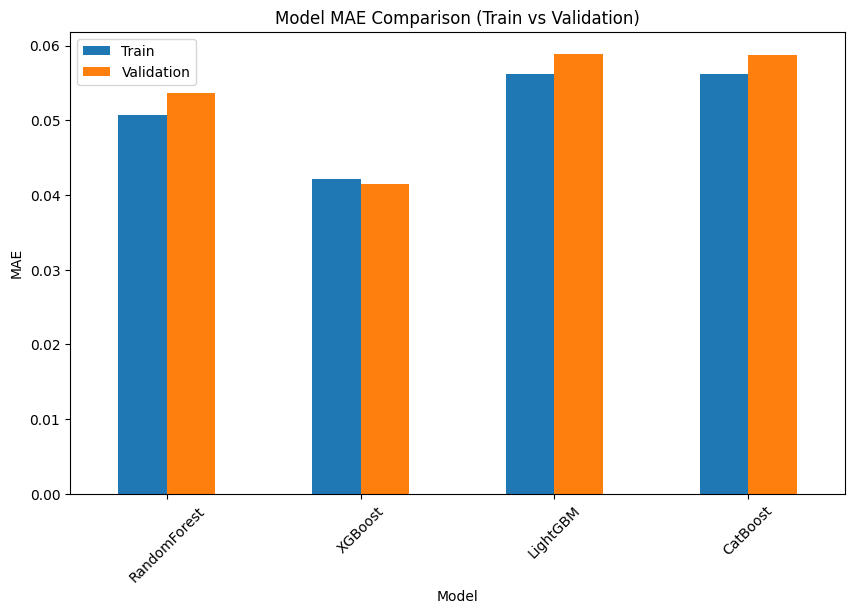

MAE 비교 시각화 완료. 다음 셀로 이동하세요.


In [95]:
# 필요한 라이브러리 임포트
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
import joblib

# 성능 메트릭 로드
mae_scores = joblib.load('mae_scores.pkl')

# MAE 비교 (막대그래프)
plt.figure(figsize=(10, 6))
mae_data = {model: [scores['Train'], scores['Validation']] for model, scores in mae_scores.items()}
mae_df = pd.DataFrame(mae_data, index=['Train', 'Validation']).T
mae_df.plot(kind='bar', ax=plt.gca())
plt.title('Model MAE Comparison (Train vs Validation)')
plt.xlabel('Model')
plt.ylabel('MAE')
plt.legend()
plt.xticks(rotation=45)
clear_output(wait=True)
display(plt.gcf())
plt.close()

print("MAE 비교 시각화 완료. 다음 셀로 이동하세요.")

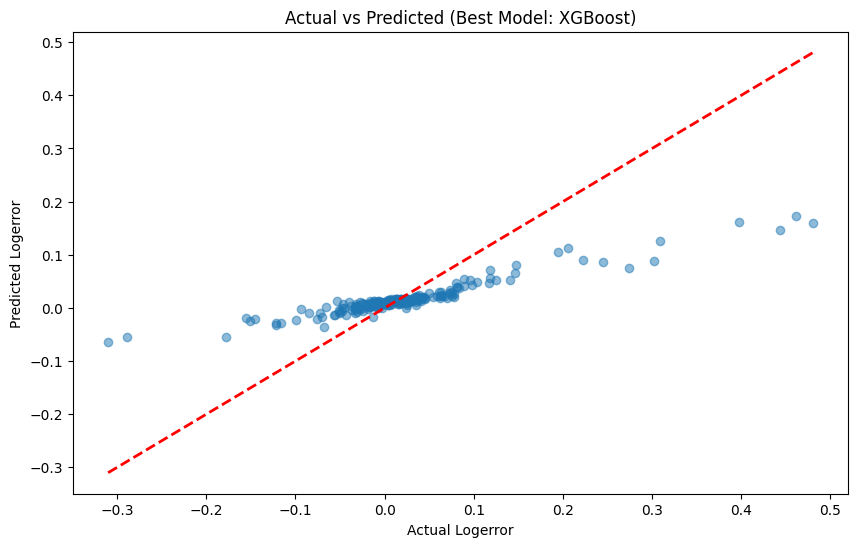

XGBoost 모델의 실제 값 vs 예측 값 시각화 완료. 다음 셀로 이동하세요.


In [99]:
# 필요한 라이브러리 임포트
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
import joblib

# 성능 메트릭 및 예측값 로드
mae_scores = joblib.load('mae_scores.pkl')
predictions = joblib.load('predictions.pkl')

# 가장 좋은 모델 선택 (Validation MAE 기준)
best_model_name = min(mae_scores, key=lambda x: mae_scores[x]['Validation'])

# 실제 값 vs 예측 값 산점도 (CatBoost)
plt.figure(figsize=(10, 6))
plt.scatter(y_val, predictions[best_model_name], alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
plt.title(f'Actual vs Predicted (Best Model: {best_model_name})')
plt.xlabel('Actual Logerror')
plt.ylabel('Predicted Logerror')
clear_output(wait=True)
display(plt.gcf())
plt.close()

print(f"{best_model_name} 모델의 실제 값 vs 예측 값 시각화 완료. 다음 셀로 이동하세요.")

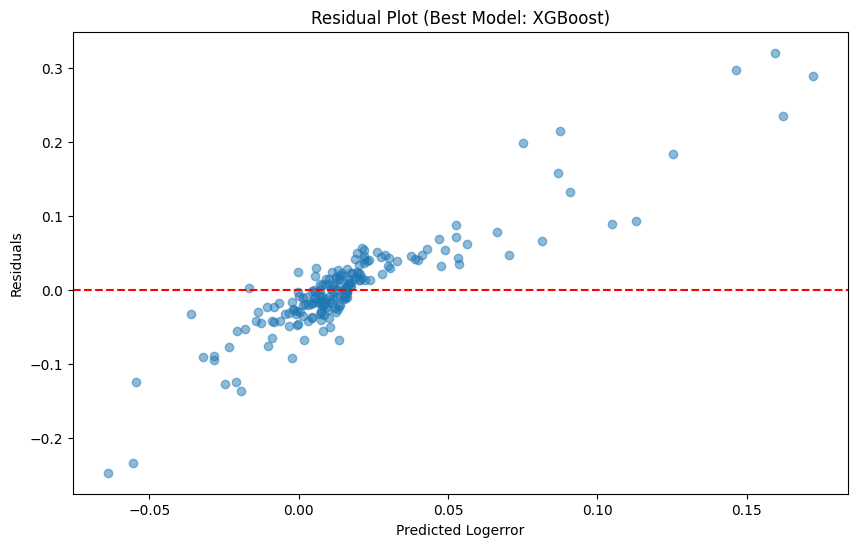

XGBoost 모델의 잔차 플롯 시각화 완료. 다음 셀로 이동하세요.


In [97]:
# 필요한 라이브러리 임포트
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output, display
import joblib

# 성능 메트릭 및 예측값 로드
mae_scores = joblib.load('mae_scores.pkl')
predictions = joblib.load('predictions.pkl')

# 가장 좋은 모델 선택 (Validation MAE 기준)
best_model_name = min(mae_scores, key=lambda x: mae_scores[x]['Validation'])

# 잔차 플롯 (CatBoost)
residuals = y_val - predictions[best_model_name]
plt.figure(figsize=(10, 6))
plt.scatter(predictions[best_model_name], residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title(f'Residual Plot (Best Model: {best_model_name})')
plt.xlabel('Predicted Logerror')
plt.ylabel('Residuals')
clear_output(wait=True)
display(plt.gcf())
plt.close()

print(f"{best_model_name} 모델의 잔차 플롯 시각화 완료. 다음 셀로 이동하세요.")

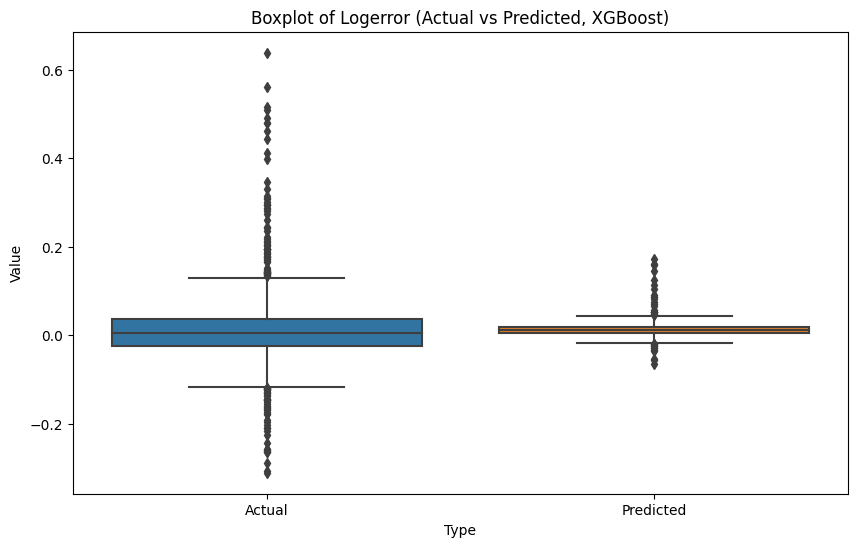

XGBoost 모델의 박스플롯 시각화 완료.


In [101]:
# 필요한 라이브러리 임포트
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output, display
import joblib

# 성능 메트릭 및 예측값 로드
mae_scores = joblib.load('mae_scores.pkl')
predictions = joblib.load('predictions.pkl')

# 가장 좋은 모델 선택 (Validation MAE 기준)
best_model_name = min(mae_scores, key=lambda x: mae_scores[x]['Validation'])

# 박스플롯 데이터 준비
data_for_boxplot = pd.DataFrame({
    'Value': np.concatenate([y_train, predictions[best_model_name]]),
    'Type': ['Actual'] * len(y_train) + ['Predicted'] * len(predictions[best_model_name])
})

# 박스플롯 (Actual vs Predicted)
plt.figure(figsize=(10, 6))
sns.boxplot(x='Type', y='Value', data=data_for_boxplot)
plt.title('Boxplot of Logerror (Actual vs Predicted, XGBoost)')
clear_output(wait=True)
display(plt.gcf())
plt.close()

print(f"{best_model_name} 모델의 박스플롯 시각화 완료.")